# Examine Clusters

This notebook is for examining the clustering algorithm used by Spyral. To use this notebook you *must* first have run the PointcloudPhase of Spyral and generated those results. The clustering algorithm will be applied to the point clouds and plots will be displayed showing the results. This is useful for tuning the various clustering parameters. Note that data generated here is NOT saved. This is only for testing. For more informations on phases checkout the [documentation](https://attpc.github.io/Spyral/).

## Configuration
First we import all the things

In [1]:
from spyral.core.point_cloud import PointCloud
from spyral.core.clusterize import form_clusters, join_clusters, cleanup_clusters, clean_clusters
from spyral.core.run_stacks import form_run_string
from spyral import ClusterParameters, OverlapJoinParameters, ContinuityJoinParameters
from spyral.core.config import TripclustParameters, HdbscanParameters, ContinuityJoinParameters
from spyral.core.point_cloud import PointCloud, sort_point_cloud_in_z


from pathlib import Path
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np

DEFAULT_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

%matplotlib widget

# Utility for syncing plot colors
def get_color(value: int) -> str:
    color_index = value
    if color_index >= len(DEFAULT_COLORS):
        color_index = color_index % len(DEFAULT_COLORS)
    elif color_index == -1:
        return "black"
    return DEFAULT_COLORS[color_index]


Now we'll load the point clouds generated by phase one. This is very similar to the previous example where we loaded traces, so please reference that section if anything is unclear.

First load the config and the workspace

In [2]:
# Some parameters
workspace_path = Path("/Volumes/researchEXT/24Mg/mg24_spyral/")

cluster_params = ClusterParameters(
    min_cloud_size=100,
    hdbscan_parameters= HdbscanParameters(
    min_points=1,min_size_scale_factor=0.15,
    min_size_lower_cutoff=10, 
    cluster_selection_epsilon=10.0,
    
    ),
    # hdbscan_parameters= None,
    tripclust_parameters=None,
    # tripclust_parameters=TripclustParameters(
    #     r=4.3,
    #     rdnn=True,
    #     k=20,
    #     n=2,
    #     a=0.01,
    #     s=0.3,
    #     sdnn=True,
    #     t=6,
    #     tauto=False,
    #     dmax=0.0, 
    #     dmax_dnn=False,
    #     ordered=True,
    #     link=0,
    #     m=5,
    #     postprocess=False,
    #     min_depth=25,
    # ),
    overlap_join=OverlapJoinParameters(
        min_cluster_size_join=15,
        circle_overlap_ratio=0.25,
    ),
    # overlap_join=None,
    continuity_join = ContinuityJoinParameters(
    join_radius_fraction=0.4,
    join_z_fraction=0.4),
    direction_threshold= 0.5,
    outlier_scale_factor=0.1,
    
)

pointcloud_path = workspace_path / "Pointcloud" # this may change if you add custom phases!

Now use the workspace to load the point cloud file, creating an event iterator so we can walk through the dataset

In [3]:
run_number = 30
point_file_path = pointcloud_path / f"{form_run_string(run_number)}.h5"
point_file = h5.File(point_file_path, 'r')

cloud_group: h5.Group = point_file.get('cloud')
min_event = cloud_group.attrs['min_event']
max_event = cloud_group.attrs['max_event']
event_iterator = iter(range(min_event, max_event+1))
print(f"First event: {min_event} Last event: {max_event}")

First event: 0 Last event: 20891


## Analysis

Re-runing the code below this cell will allow you to walk through the dataset in order, as long as you do not re-run the cells  above this!

Now we'll load the next event in the dataset (or a specific hardcoded one)

In [270]:
# event = 1945978
event = 147 # You can hardcode a specific event to debug
# event = 1
if event is None:
    try:
        event = next(event_iterator)
    except StopIteration:
        raise Exception("You ran out of events (wow!) for this file! Select a new file to analyze.")
print(f'Event {event}')
event_name = f"cloud_{event}"
if not event_name in cloud_group:
    raise Exception("This was a downscale beam event and has been removed from the analysis! Run this cell again to select a new event.")
event_data = cloud_group[f'cloud_{event}']
cloud = PointCloud(event, event_data[:].copy())
print(f'Cloud size: {len(cloud)}')
# Close any open plots to avoid memory problems
plt.close()

Event 147
Cloud size: 343


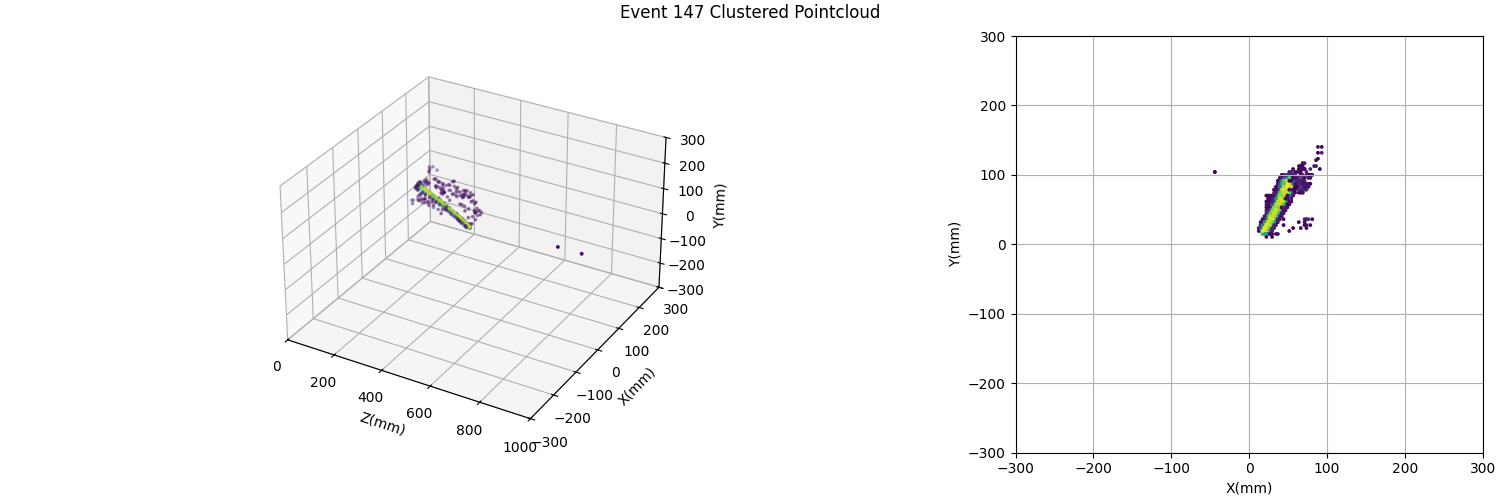

In [271]:
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)
axs["A"].scatter(cloud.data[:, 2], cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3, label="Pointcloud")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].scatter(cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3)
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
plt.suptitle(f"Event {event} Clustered Pointcloud")
axs["B"].grid()

Above you should see two plots, one is the 3-D point cloud and the other is the pad plane projection. In the next cell we'll apply HDBSCAN to the data and cluster it.

In [221]:
sort_point_cloud_in_z(cloud)
clusters, labels = form_clusters(cloud, cluster_params)
total_points = 0
for cluster in clusters:
    total_points += len(cluster.point_cloud)
print(f"Total non-noise points: {total_points}")

HDBSCAN clustering with min_size=88 for point cloud of size 588
Total non-noise points: 588


We can then plot the clusters together to check the performance of the algorithm

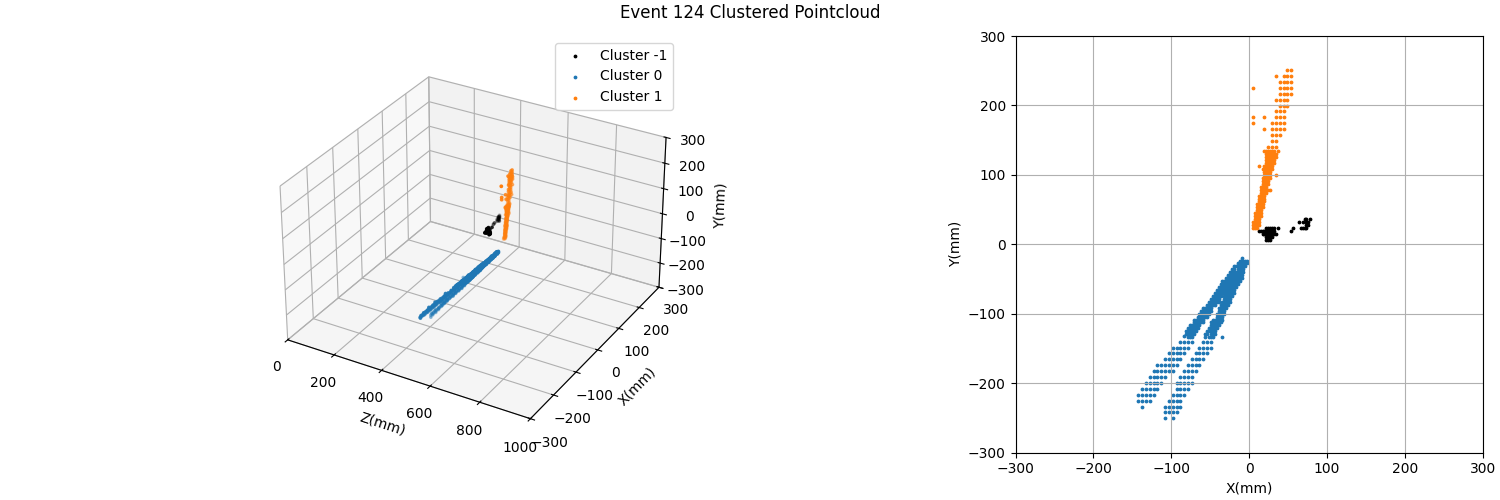

In [222]:
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)

for cluster in clusters:
    axs["A"].scatter(cluster.point_cloud.data[:, 2], cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
    axs["B"].scatter(cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
plt.suptitle(f"Event {event} Clustered Pointcloud")
axs["B"].grid()
axs["A"].legend()

Above shows the different clusters identified by the algorithm, with the labels supplied by the algorithm. Points labeled -1 were identified to be noise. 

Typically the algorithm breaks trajectories into many clusters due to varying pad denisty, trajectory gaps, etc. So we need to rejoin these cluster pieces into an actual trajectory cluster. We do this by fitting a circle to each cluster and seeing how much the circles overlap. If they overlap enough, they are deemed to be from the same trajectory. Clusters are joined until no more joins are possible. 

In [66]:
clean, labels = clean_clusters(clusters, cluster_params, labels)

In [67]:
if cluster_params.overlap_join is not None or cluster_params.continuity_join is not None:
    joined, labels = join_clusters(clean, cluster_params, labels)
else:
    joined = clean


Now we can again plot our clusters

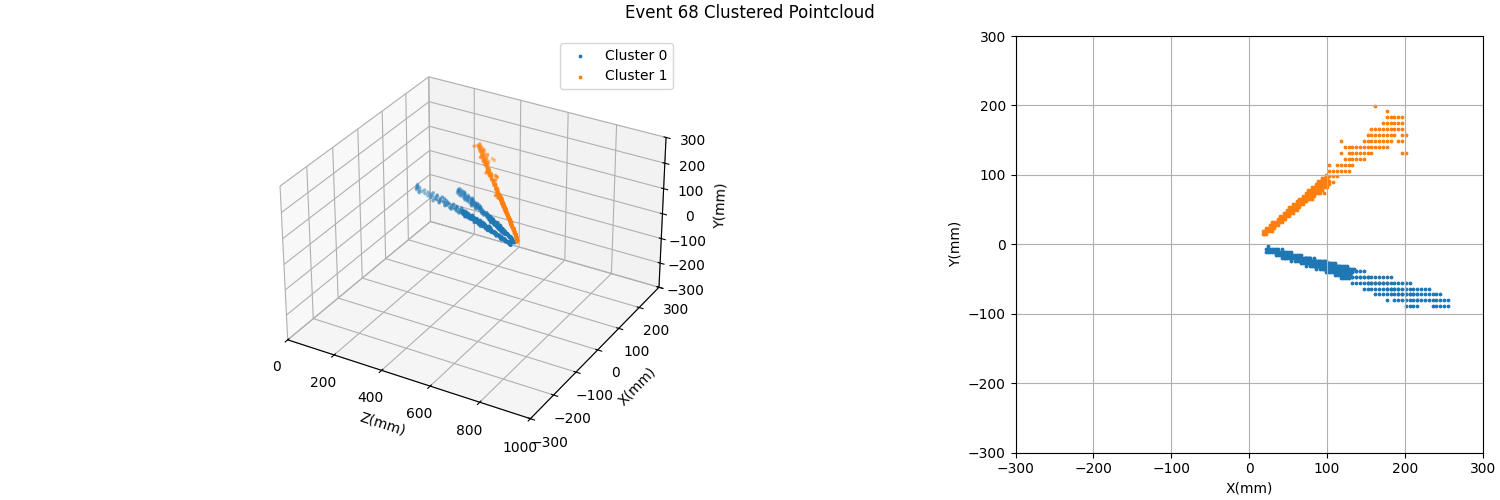

In [68]:
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)

for cluster in joined:
    axs["A"].scatter(cluster.point_cloud.data[:, 2], cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
    axs["B"].scatter(cluster.point_cloud.data[:, 0], cluster.point_cloud.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
plt.suptitle(f"Event {event} Clustered Pointcloud")
axs["B"].grid()
axs["A"].legend()

Now you should see well defined trajectory clusters! If you don't, try tweaking some of the parameters or cycling to a different point cloud.

Finally, a cleanup pass is run on the joined clusters to reduce noise. Note that we change types here. Previously our clusters were of type LabeledCloud, a temporary holding type. Now our clusters are of type Cluster, so the semantics change a small amount.

In [168]:
cleaned_clusters, labels = cleanup_clusters(joined, cluster_params, labels)

We can again plot our projections to examine the results

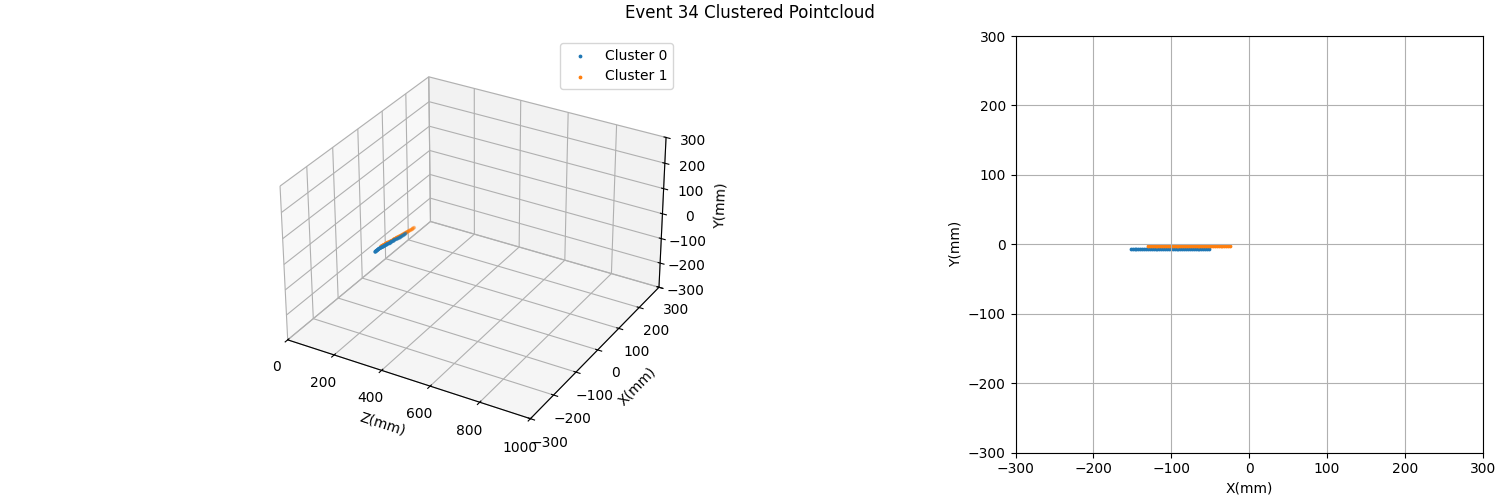

In [169]:
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)

for cluster in cleaned_clusters:
    axs["A"].scatter(cluster.data[:, 2], cluster.data[:, 0], cluster.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
    axs["B"].scatter(cluster.data[:, 0], cluster.data[:, 1], c=get_color(cluster.label), s=3, label=f"Cluster {cluster.label}")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
plt.suptitle(f"Event {event} Clustered Pointcloud")
axs["B"].grid()
axs["A"].legend()

If you re-run the cells in the Analysis section, you'll walk through the dataset in order

### Conclusion

We've now generated clusters from our point clouds and tested the parameters, so now you can take these parameters and run the full phase 2 analysis. The next step is perfom basic physics analysis and estimate some pararameters.